# EfficientNetB3 Model 2 - APTOS 2019 competition with Keras

The inference kernel of this notebook can be found here: https://www.kaggle.com/fanconic/efficientnetb3-regression-single-inference?scriptVersionId=19806108

- LB Score: 0.787
- Private Score: 0.905

In this kernel we will implement EfficientNet for medical images ([APTOS 2019](https://www.kaggle.com/c/aptos2019-blindness-detection) competition). EfficientNet was released this June (2019) by Google AI and is the new state-of-the-art on ImageNet. It introduces a systematic way to scale CNN (Convolutional Neural Networks) in a nearly optimal way. For this kernel we will use the B3 version, but feel free to play with the larger models. This kernel provides weights for EfficientNetB0 through B5. Weights for EfficientNetB6 and B7 can be found in [Google AI's repository for EfficientNet](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet). I highly recommend you to read [the EfficientNet paper](https://arxiv.org/pdf/1905.11946.pdf) as it signifies a fundamental shift in how the Deep Learning community will approach model scaling!

Also, check out this [video on EfficientNet by Henry AI Labs](https://youtu.be/3svIm5UC94I) for a clear explanation!

If you like this Kaggle kernel, feel free to give an upvote and leave a comment!

Image: an overview of model architectures and their performance on [ImageNet](http://www.image-net.org/). We can see that EfficientNet achieves state-of-the-art and uses a lot less parameters than most modern CNN architectures.

[Source: EfficientNet Paper](https://arxiv.org/pdf/1905.11946.pdf)

![](https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/params.png)

## Dependencies <a id="1"></a>

Special thanks to [qubvel](https://github.com/qubvel/efficientnet) for sharing an amazing wrapper to get the EfficientNet architecture in one line of code!

In [1]:
import os
import sys
# Repository source: https://github.com/qubvel/efficientnet
sys.path.append(os.path.abspath('../input/efficientnet/efficientnet-master/efficientnet-master/'))
from efficientnet import EfficientNetB3
import gc

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
# Standard dependencies
import cv2
import time
import scipy as sp
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
from keras import backend as K
from keras.activations import elu
from keras.optimizers import Adam, Optimizer
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

# Path specifications
KAGGLE_DIR = '../input/aptos2019-blindness-detection/'
TRAIN_IMG_PATH = '../input/diabetic-retinopathy-resized/resized_train/resized_train/'
TEST_DF_PATH = KAGGLE_DIR + 'test.csv'
VAL_IMG_PATH = KAGGLE_DIR + "train_images/"
TEST_IMG_PATH = KAGGLE_DIR + 'test_images/'

# Specify title of our final model
SAVED_MODEL_NAME = 'effnet_modelB3.h5'

# Set seed for reproducability
seed = 11
np.random.seed(seed)
tf.set_random_seed(seed)

# For keeping time. GPU limit for this competition is set to ± 9 hours.
t_start = time.time()

# File sizes and specifications
print('\n# Files and file sizes')
for file in os.listdir(KAGGLE_DIR):
    print('{}| {} MB'.format(file.ljust(30), 
                             str(round(os.path.getsize(KAGGLE_DIR + file) / 1000000, 2))))


# Files and file sizes
test.csv                      | 0.03 MB
test_images                   | 0.07 MB
train.csv                     | 0.05 MB
sample_submission.csv         | 0.03 MB
train_images                  | 0.13 MB


## Preparation <a id="2"></a>

By examining the data we can readily see that we do not have that much data (± 700 samples per class). It is probably a good idea to use data augmentation to increase robustness of our model (See the modeling section).

We could also try to use additional data from previous competitions to increase performance. Although I do not implement this in the kernel, feel free to experiment with adding data. Additional data can be found in [this Kaggle dataset](https://www.kaggle.com/benjaminwarner/resized-2015-2019-blindness-detection-images) (± 35000 additional images).

In [3]:
new_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
old_train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels_cropped.csv')
duplicates = pd.read_csv('../input/aptos-trained-weights/inconsistent.csv')
print(new_train.shape)
print(old_train.shape)
print(duplicates.shape)

for img_name in duplicates['id_code'].values:
    new_train = new_train[new_train['id_code'] != img_name]
print(new_train.shape)

(3662, 2)
(35108, 4)
(60, 1)
(3602, 2)


In [4]:
old_train = old_train[['image','level']]
old_train.columns = new_train.columns
old_train.diagnosis.value_counts()

'''
# path columns
new_train['id_code'] = '../input/aptos2019-blindness-detection/train_images/' + new_train['id_code'].astype(str) + '.png'
old_train['id_code'] = '../input/diabetic-retinopathy-resized/resized_train/resized_train/' + old_train['id_code'].astype(str) + '.jpeg'
'''
# path columns
new_train['id_code'] = new_train['id_code'].astype(str) + '.png'
old_train['id_code'] = old_train['id_code'].astype(str) + '.jpeg'


train_df = old_train.copy()
val_df = new_train.copy()

In [5]:
print("Image IDs (Train)")
print(f"Training Images: {train_df.shape[0]}")
display(train_df.head())

print("Image IDs (Validation)")
print(f"Validation Images: {val_df.shape[0]}")
display(val_df.head())

print("Image IDs (TEST)")
test_df = pd.read_csv(TEST_DF_PATH)
# Add extension to id_code
test_df['id_code'] = test_df['id_code'] + ".png"
print(f"Testing Images: {test_df.shape[0]}")
display(test_df.head())

Image IDs (Train)
Training Images: 35108


,id_code,diagnosis
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1


Image IDs (Validation)
Validation Images: 3602


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Image IDs (TEST)
Testing Images: 1928


,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


In [6]:
# Specify image size
IMG_WIDTH = 320
IMG_HEIGHT = 320
CHANNELS = 3
BATCH_SIZE = 32

## Metric (Quadratic Weighted Kappa) <a id="3"></a>

The metric that is used for this competition is Quadratic Weighted Kappa (QWK) ([Kaggle's Explanation](https://www.kaggle.com/c/aptos2019-blindness-detection/overview/evaluation)) 

The formula for weighted kappa is:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/2a496e1cef7d812b83bdbb725d291748cf0183f5)

In this case we are going to optimize Mean Squared Error (MSE) (See Modeling section) since we are using regression and by optimizing MSE we are also optimizing QWK as long as we round predictions afterwards. Additionally we are going to same the model which achieves the best QWK score on the validation data through a custom Keras Callback.

For a more detailed and practical explanation of QWK I highly recommend [this Kaggle kernel](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps).

In [7]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    """
    generator.reset()
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

In [8]:
class Metrics(Callback):
    """
    A custom Keras callback for saving the best model
    according to the Quadratic Weighted Kappa (QWK) metric
    """
    
    def on_train_begin(self, logs={}):
        """
        Initialize list of QWK scores on validation data
        """
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        and saves the model if the score is better
        than previous epochs
        """
        y_pred, labels = get_preds_and_labels(model, val_generator)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {_val_kappa:.4f}")
        
        # Save best model
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save(SAVED_MODEL_NAME)
        return

## EDA (Exploratory Data Analysis) <a id="4"></a>

For EDA on image datasets I think one should at least examine the label distribution, the images before preprocessing and the images after preprocessing. Through examining these three aspects we can get a good sense of the problem. Note that the distribution on the test set can still vary wildly from the training data.

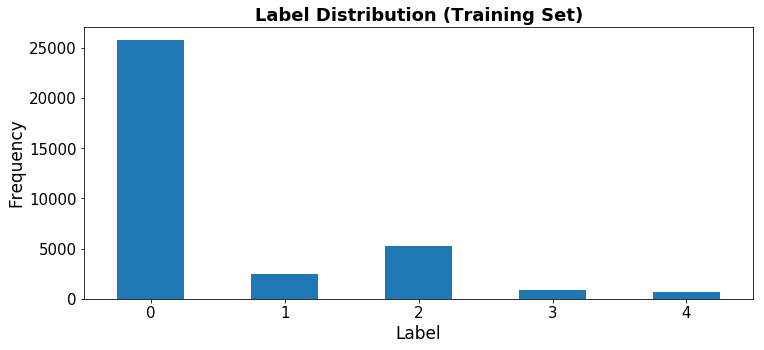

In [9]:
# Label distribution
train_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

We will visualize a random image from every label to get a general sense of the distinctive features that seperate the classes. We will take this into account and try to enhance these features in our preprocessing. For these images there some to be increasingly more spots and stains on the retina as diabetic retinopathy worsens.

## Preprocessing <a id="5"></a>

Here we will use the auto-cropping method with Ben's preprocessing as explained in [this kernel](https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping).

In [10]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
# Make all images circular (possible data loss)
def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    
    return img 

def preprocess_image_old(img):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    """
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,10), -4, 128)
    return image

def preprocess_image_new(img):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    """
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,10), -4, 128)
    return image

After preprocessing we have managed to enhance the distinctive features in the images. This will increase performance when we train our EfficientNet model.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: `item` has been deprecated and will be removed in a future version
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `item` has been deprecated and will be removed in a future version
  


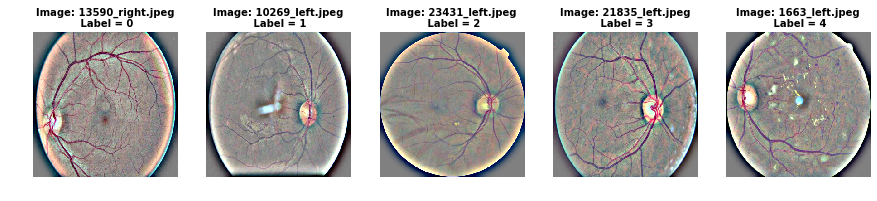

In [11]:
# Example of preprocessed images from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = cv2.imread(f"{TRAIN_IMG_PATH}{image_name}")
    X = preprocess_image_new(X)
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

## Modeling (EfficientNetB3) <a id="6"></a>

Since we want to optimize the Quadratic Weighted Kappa score we can formulate this challenge as a regression problem. In this way we are more flexible in our optimization and we can yield higher scores than solely optimizing for accuracy. We will optimize a pre-trained EfficientNetB3 with a few added layers. The metric that we try to optimize is the [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error). This is the mean of squared differences between our predictions and labels, as showed in the formula below. By optimizing this metric we are also optimizing for Quadratic Weighted Kappa if we round the predictions afterwards.

![](https://study.com/cimages/multimages/16/4e7cf150-0179-4d89-86f2-5cbb1f51c266_meansquarederrorformula.png)

Since we are not provided with that much data (3662 images), we will augment the data to make the model more robust. We will rotate the data on any angle. Also, we will flip the data both horizontally and vertically. Lastly, we will divide the data by 128 for normalization.

In [12]:
# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rotation_range=90,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range= 0.3,
                                   fill_mode= 'constant',
                                   brightness_range=(0.5,2),
                                   cval = 0,
                                   preprocessing_function=preprocess_image_old,
                                   rescale=1./255
                                  )

val_datagen = ImageDataGenerator(rescale=1./255,
                                 preprocessing_function=preprocess_image_new,
                                  )


# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='id_code', 
                                                    y_col='diagnosis',
                                                    directory = TRAIN_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='other',
                                                    seed=seed)

val_generator = val_datagen.flow_from_dataframe(val_df, 
                                                  x_col='id_code', 
                                                  y_col='diagnosis',
                                                  directory = VAL_IMG_PATH,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='other',
                                                  shuffle= False,
                                                  seed=seed)

Found 35108 validated image filenames.
Found 3602 validated image filenames.


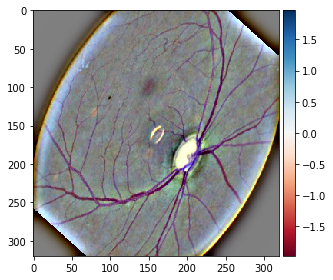

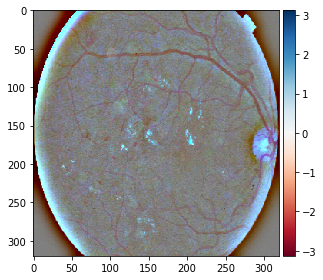

In [13]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x1, y1 = train_generator[0]
x2, y2 = val_generator[0]
imshow(x1[0])
imshow(x2[0])

Thanks to the amazing wrapper by [qubvel](https://github.com/qubvel/efficientnet) we can load in a model like the Keras API. We specify the input shape and that we want the model without the top (the final Dense layer). Then we load in the weights which are provided in [this Kaggle dataset](https://www.kaggle.com/ratthachat/efficientnet-keras-weights-b0b5).

In [14]:
# Load in EfficientNetB3
effnet = EfficientNetB3(weights=None,
                        include_top=False,
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))

effnet.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b3_imagenet_1000_notop.h5')

def build_model():
    """
    A custom implementation of EfficientNetB3
    for the APTOS 2019 competition
    (Regression with 5 classes)
    """
    model = Sequential()
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(5, activation=elu))
    model.add(Dense(1, activation="linear"))

    return model

# Initialize our model
model = build_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 10, 10, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 1536)              6144      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 7685      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 10,797,363
Trainable params: 10,706,995
Non-trainable params: 90,368
___________________________________________________________

In [15]:
# For tracking Quadratic Weighted Kappa score and saving best weights
kappa_metrics = Metrics()
# Monitor MSE to avoid overfitting
rlrop = ReduceLROnPlateau(monitor='val_loss', 
                                  patience=5,
                                  verbose=1,
                                  factor=.5, 
                                  min_lr=1e-7)

cp = ModelCheckpoint('val_model_2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')


### Warm Up Phase

As we are using ADAM optimizer, we initially train one epoch on the old image data with a very small learning rate. This prevents the model to get stuck in bad local optimums.


In [16]:
# Warm Up 1
model.compile(loss='mse',
              optimizer=Adam(1e-6, decay=1e-6), 
              metrics=['mse', 'acc'])


print(K.eval(model.optimizer.lr))

1e-06


In [17]:
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=1,
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics])

Epoch 1/1
1097/1097 [==============================] - 2034s 2s/step - loss: 3.3021 - mean_squared_error: 3.3021 - acc: 0.2337 - val_loss: 5.1542 - val_mean_squared_error: 5.1542 - val_acc: 0.1911
val_kappa: 0.2083
Validation Kappa has improved. Saving model.


### Pretrain

Now we pretrain the model on the old competition images. There are roughly 35000 images, thus we only train for four epochs. Additionally, we adjust the learning rate to 0.0001.

In [18]:
K.set_value(model.optimizer.lr, 1e-4)
print(K.eval(model.optimizer.lr))

1e-04


In [19]:
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=5,
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics, cp])

Epoch 1/5
1097/1097 [==============================] - 2000s 2s/step - loss: 1.6987 - mean_squared_error: 1.6987 - acc: 0.3385 - val_loss: 0.8512 - val_mean_squared_error: 0.8512 - val_acc: 0.5501
val_kappa: 0.6226
Validation Kappa has improved. Saving model.

Epoch 00001: val_loss improved from inf to 0.85116, saving model to val_model_2.h5
Epoch 2/5
1097/1097 [==============================] - 1993s 2s/step - loss: 0.9374 - mean_squared_error: 0.9374 - acc: 0.4734 - val_loss: 0.5583 - val_mean_squared_error: 0.5583 - val_acc: 0.6532
val_kappa: 0.8012
Validation Kappa has improved. Saving model.

Epoch 00002: val_loss improved from 0.85116 to 0.55832, saving model to val_model_2.h5
Epoch 3/5
1097/1097 [==============================] - 1989s 2s/step - loss: 0.7477 - mean_squared_error: 0.7477 - acc: 0.5360 - val_loss: 0.4530 - val_mean_squared_error: 0.4530 - val_acc: 0.6627
val_kappa: 0.8507
Validation Kappa has improved. Saving model.

Epoch 00003: val_loss improved from 0.55832 to 

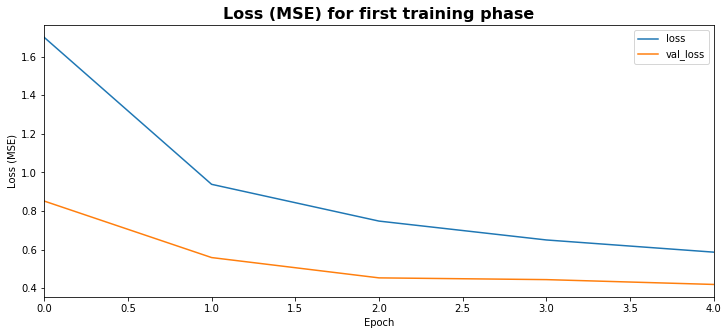

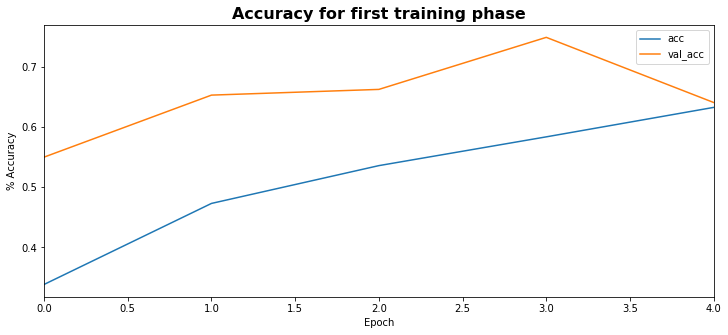

In [20]:
# Visualize mse for first training phase
history_df = pd.DataFrame(model.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE) for first training phase", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['acc', 'val_acc']].plot(figsize=(12,5))
plt.title("Accuracy for first training phase", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

### Training

In the second training phase we unfreeze all layers a fine-tune all layers of the model with the new competition data. Therefore, we have to split the new data set into training and valuation set and create new flow generators.

In [21]:
from sklearn.model_selection import train_test_split

train_df2, val_df2 = train_test_split(val_df, random_state=seed)
display(train_df2.head())
display(val_df2.head())
print(train_df2.shape)
print(val_df2.shape)

,id_code,diagnosis
2242,9dab2e6ba44b.png,2
330,18af532e7e1e.png,2
3179,dd110d2b8c21.png,2
878,3f82631e9080.png,0
3186,dde43aa22ae6.png,2


,id_code,diagnosis
2144,974c7d7b9c64.png,0
2600,b49b2fac2514.png,4
543,269b44e628eb.png,3
2804,c21eb81de9fc.png,0
674,2fe06bedb2c4.png,4


(2701, 2)
(901, 2)


In [22]:
print(round(val_df.diagnosis.value_counts()/len(val_df)*100,4))
print(round(val_df2.diagnosis.value_counts()/len(val_df2)*100,4))
print(round(train_df2.diagnosis.value_counts()/len(train_df2)*100,4))

0    50.0000
2    27.1516
1     9.9944
4     7.8567
3     4.9972
Name: diagnosis, dtype: float64
0    51.0544
2    27.3030
4     8.9900
1     8.8790
3     3.7736
Name: diagnosis, dtype: float64
0    49.6483
2    27.1011
1    10.3665
4     7.4787
3     5.4054
Name: diagnosis, dtype: float64


In [23]:
# Use the dataframe to define train and validation generators
# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rotation_range=90,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range= 0.3,
                                   fill_mode= 'constant',
                                   brightness_range=(0.5,2),
                                   cval = 0,
                                   preprocessing_function=preprocess_image_new,
                                   rescale=1./255
                                   )

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_image_new,
                                 rescale=1./255
                                   )


train_generator = train_datagen.flow_from_dataframe(train_df2, 
                                                    x_col='id_code', 
                                                    y_col='diagnosis',
                                                    directory = VAL_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='other',
                                                    seed=seed)

val_generator = val_datagen.flow_from_dataframe(val_df2, 
                                                  x_col='id_code', 
                                                  y_col='diagnosis',
                                                  directory = VAL_IMG_PATH,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='other',
                                                  shuffle= False,
                                                  seed=seed)

gc.collect()

Found 2701 validated image filenames.
Found 901 validated image filenames.


5232

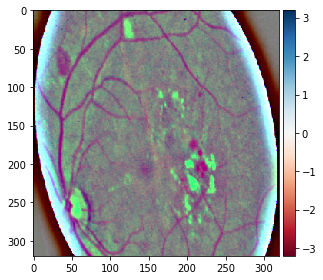

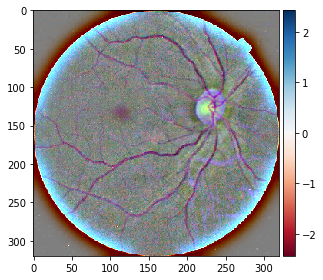

In [24]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x1, y1 = train_generator[0]
x2, y2 = val_generator[0]
imshow(x1[0])
imshow(x2[0])

train_generator.reset()
val_generator.reset()

In [25]:
model.load_weights('val_model_2.h5')

In [26]:
# Start second training phase (fine-tune all layers)
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics, rlrop, cp])

Epoch 1/20
84/84 [==============================] - 480s 6s/step - loss: 0.6311 - mean_squared_error: 0.6311 - acc: 0.6187 - val_loss: 0.3472 - val_mean_squared_error: 0.3472 - val_acc: 0.7377
val_kappa: 0.8757
Validation Kappa has improved. Saving model.

Epoch 00001: val_loss improved from 0.41898 to 0.34722, saving model to val_model_2.h5
Epoch 2/20
84/84 [==============================] - 416s 5s/step - loss: 0.4502 - mean_squared_error: 0.4502 - acc: 0.6634 - val_loss: 0.3640 - val_mean_squared_error: 0.3640 - val_acc: 0.7814
val_kappa: 0.8573

Epoch 00002: val_loss did not improve from 0.34722
Epoch 3/20
84/84 [==============================] - 415s 5s/step - loss: 0.4274 - mean_squared_error: 0.4274 - acc: 0.6792 - val_loss: 0.3353 - val_mean_squared_error: 0.3353 - val_acc: 0.8036
val_kappa: 0.8868
Validation Kappa has improved. Saving model.

Epoch 00003: val_loss improved from 0.34722 to 0.33533, saving model to val_model_2.h5
Epoch 4/20
84/84 [==============================]

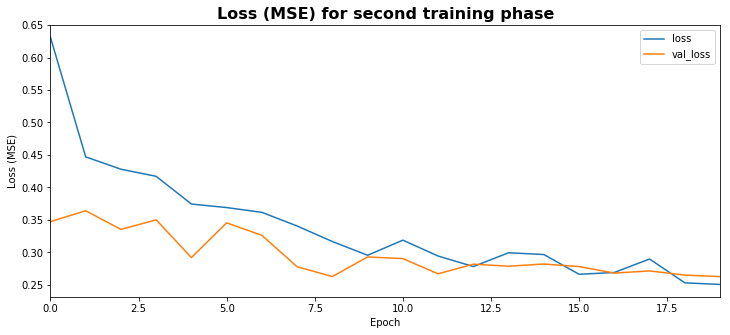

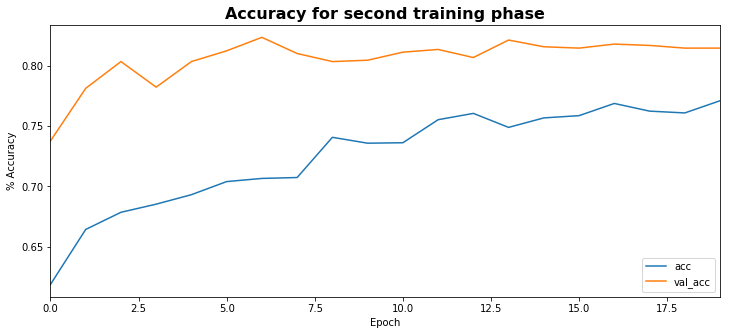

In [27]:
# Visualize MSE for second training phase
history_df = pd.DataFrame(model.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE) for second training phase", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['acc', 'val_acc']].plot(figsize=(12,5))
plt.title("Accuracy for second training phase", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

## Evaluation <a id="7"></a>

In [28]:
# Load best weights according to validation mse score
model.load_weights('val_model_2.h5')

To evaluate our performance we predict values from the generator and round them of to the nearest integer to get valid predictions. After that we calculate the Quadratic Weighted Kappa score on the training set and the validation set.

In [29]:
# Calculate QWK on train set
y_train_preds, train_labels = get_preds_and_labels(model, train_generator)
y_train_preds = np.rint(y_train_preds).astype(np.uint8).clip(0, 4)

# Calculate score
train_score = cohen_kappa_score(train_labels, y_train_preds, weights="quadratic")

# Calculate QWK on validation set
y_val_preds, val_labels = get_preds_and_labels(model, val_generator)
y_val_preds = np.rint(y_val_preds).astype(np.uint8).clip(0, 4)

# Calculate score
val_score = cohen_kappa_score(val_labels, y_val_preds, weights="quadratic")

In [30]:
print(f"The Training Cohen Kappa Score is: {round(train_score, 5)}")
print(f"The Validation Cohen Kappa Score is: {round(val_score, 5)}")

The Training Cohen Kappa Score is: 0.93637
The Validation Cohen Kappa Score is: 0.91815


We can optimize the validation score by doing a [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) over rounding thresholds instead of doing "normal" rounding. The "OptimizedRounder" class by [Abhishek Thakur](https://www.kaggle.com/abhishek) is a great way to do this. The original class can be found in [this Kaggle kernel](https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa).

In [31]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa score
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [32]:
# Optimize on validation data and evaluate again
y_val_preds, val_labels = get_preds_and_labels(model, val_generator)
optR = OptimizedRounder()
optR.fit(y_val_preds, val_labels)
coefficients = optR.coefficients()
opt_val_predictions = optR.predict(y_val_preds, coefficients)
new_val_score = cohen_kappa_score(val_labels, opt_val_predictions, weights="quadratic")

In [33]:
print(f"Optimized Thresholds:\n{coefficients}\n")
print(f"The Validation Quadratic Weighted Kappa (QWK)\n\
with optimized rounding thresholds is: {round(new_val_score, 5)}\n")
print(f"This is an improvement of {round(new_val_score - val_score, 5)}\n\
over the unoptimized rounding")

Optimized Thresholds:
[0.54213048 1.3659179  2.52735944 3.3134695 ]

The Validation Quadratic Weighted Kappa (QWK)
with optimized rounding thresholds is: 0.92309

This is an improvement of 0.00494
over the unoptimized rounding


In [34]:
# Check kernels run-time. GPU limit for this competition is set to ± 9 hours.
t_finish = time.time()
total_time = round((t_finish-t_start) / 3600, 4)
print('Kernel runtime = {} hours ({} minutes)'.format(total_time, 
                                                      int(total_time*60)))

Kernel runtime = 7.2915 hours (437 minutes)
